In [1]:
!wget -c https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz

--2024-10-15 20:43:34--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  2.40MB/s    in 2m 17s  

2024-10-15 20:45:52 (2.40 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [9]:
!tar -xzf 102flowers.tgz

In [10]:
!mv jpg 102flowers

In [11]:
import torch

In [14]:
from torchvision import transforms

data_dir = '102flowers'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
pip install scipy


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
from torch.utils.data import Dataset
from scipy.io import loadmat
from PIL import Image
import os 


class FlowersDataset(Dataset):
    def __init__(self, root_dir, mat_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = loadmat(mat_file)['labels'][0]
        self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx] - 1# Adjust labels to start from 0

        if self.transform:
            image = self.transform(image)

        return image, label

In [21]:
data_dir = '102flowers/'
mat_file = 'imagelabels.mat'

In [22]:
dataset = FlowersDataset(data_dir, mat_file, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

In [23]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [24]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import numpy as np

model = resnet50(weights=ResNet50_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False


num_classes = len(np.unique(dataset.labels))
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
24.0%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

57.0%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

87.4%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Cur

In [25]:
from torch import optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [26]:
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    accuracy = 100 * correct / total
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/10], Train Loss: 2.7096, Val Loss: 1.5411, Accuracy: 83.03%
Epoch [2/10], Train Loss: 0.9789, Val Loss: 0.8579, Accuracy: 89.50%
Epoch [3/10], Train Loss: 0.5355, Val Loss: 0.6574, Accuracy: 90.48%
Epoch [4/10], Train Loss: 0.3510, Val Loss: 0.5391, Accuracy: 91.39%
Epoch [5/10], Train Loss: 0.2490, Val Loss: 0.4583, Accuracy: 92.43%
Epoch [6/10], Train Loss: 0.1845, Val Loss: 0.4117, Accuracy: 92.49%
Epoch [7/10], Train Loss: 0.1403, Val Loss: 0.3774, Accuracy: 92.74%
Epoch [8/10], Train Loss: 0.1147, Val Loss: 0.3697, Accuracy: 93.28%
Epoch [9/10], Train Loss: 0.0904, Val Loss: 0.3365, Accuracy: 93.41%
Epoch [10/10], Train Loss: 0.0758, Val Loss: 0.3213, Accuracy: 93.65%


In [27]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.7/163.7 kB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 9.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 6.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 9.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.2 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
class_names = [f'Class {i}' for i in range(num_classes)]  # Replace with actual class names if available

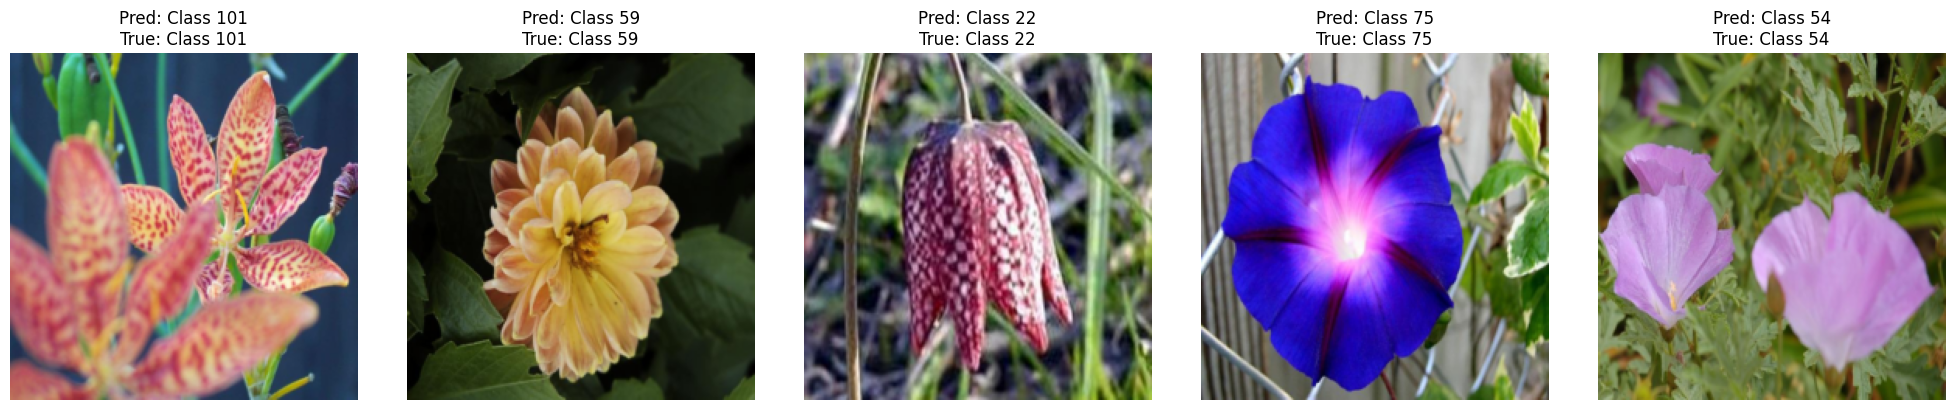

In [29]:
import matplotlib.pyplot as plt


def show_sample_predictions(model, data_loader, class_names, num_samples=5):
    model.eval()
    fig, axs = plt.subplots(1, num_samples, figsize=(20, 4))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            if i == num_samples:
                break
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            img = inputs[0].cpu().permute(1, 2, 0)
            img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            img = img.numpy()
            img = np.clip(img, 0, 1)
            
            axs[i].imshow(img)
            axs[i].set_title(f'Pred: {class_names[preds[0]]}\nTrue: {class_names[labels[0]]}')
            axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# After training
show_sample_predictions(model, val_loader, class_names)

In [32]:
def predict_image(model, image_path, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    return class_names[predicted.item()]

# Test on a new image
new_image_path = 'image.jpg'
prediction = predict_image(model, new_image_path, class_names)
print(f'Predicted class: {prediction}')

Predicted class: Class 93


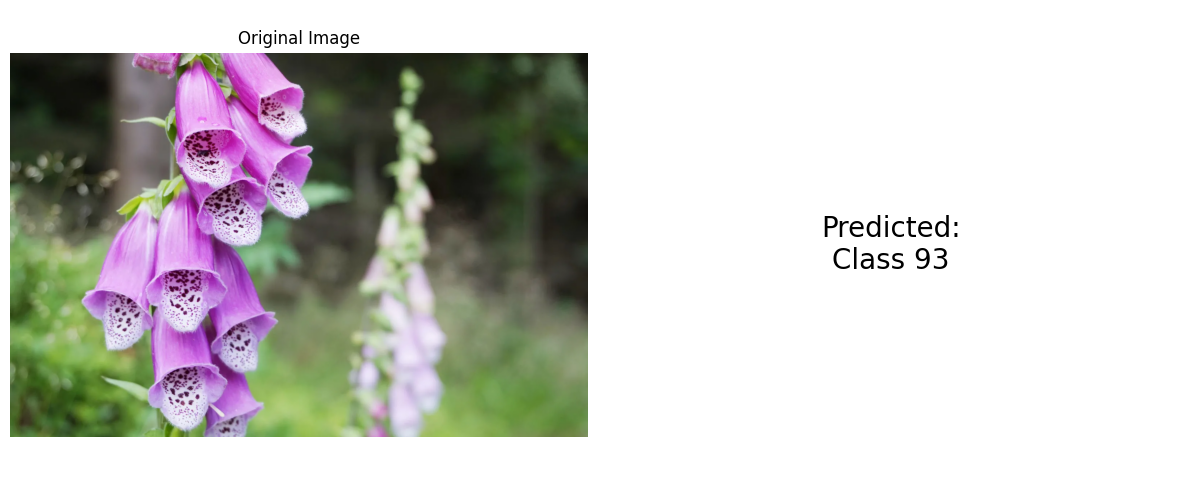

Predicted class: Class 93


In [37]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_display_image(model, image_path, class_names):
    model.eval()
    # Open and display original image
    original_image = Image.open(image_path).convert('RGB')
    
    # Prepare image for model
    image = transform(original_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    predicted_class = class_names[predicted.item()]
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Display original image
    ax1.imshow(original_image)
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    # Display prediction
    ax2.text(0.5, 0.5, f'Predicted:\n{predicted_class}', 
             horizontalalignment='center', verticalalignment='center', fontsize=20)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class

# Test on a new image
new_image_path = 'foxglove.jpg'
prediction = predict_and_display_image(model, new_image_path, class_names)
print(f'Predicted class: {prediction}')

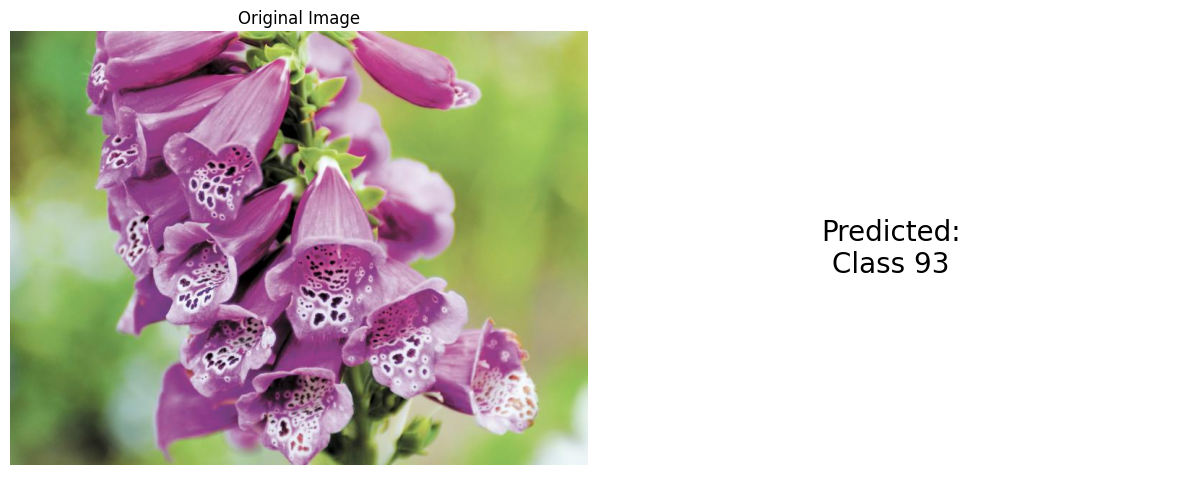

Predicted class: Class 93


In [38]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_display_image(model, image_path, class_names):
    model.eval()
    # Open and display original image
    original_image = Image.open(image_path).convert('RGB')
    
    # Prepare image for model
    image = transform(original_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    predicted_class = class_names[predicted.item()]
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Display original image
    ax1.imshow(original_image)
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    # Display prediction
    ax2.text(0.5, 0.5, f'Predicted:\n{predicted_class}', 
             horizontalalignment='center', verticalalignment='center', fontsize=20)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class

# Test on a new image
new_image_path = 'foxglove2.jpg'
prediction = predict_and_display_image(model, new_image_path, class_names)
print(f'Predicted class: {prediction}')

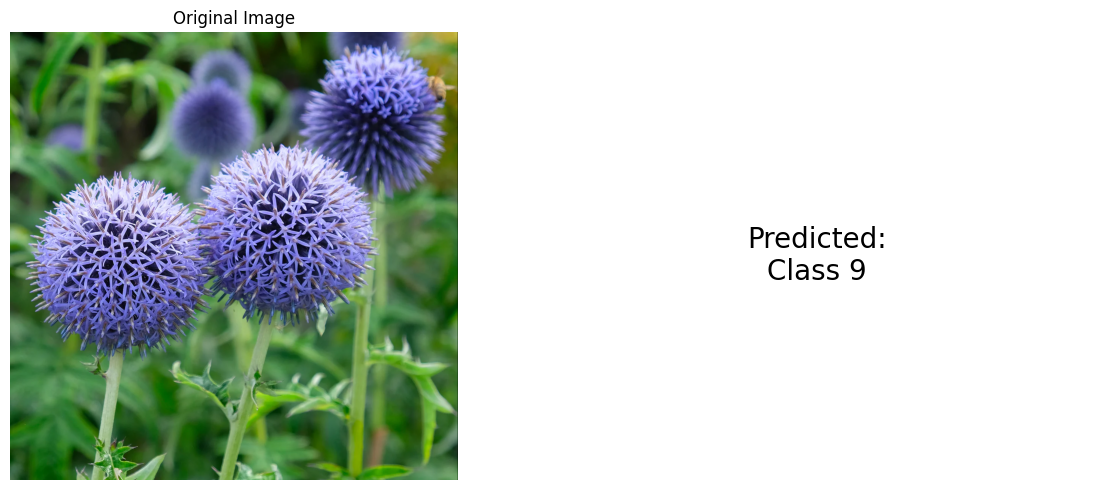

Predicted class: Class 9


In [49]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_display_image(model, image_path, class_names):
    model.eval()
    # Open and display original image
    original_image = Image.open(image_path).convert('RGB')
    
    # Prepare image for model
    image = transform(original_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    predicted_class = class_names[predicted.item()]
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Display original image
    ax1.imshow(original_image)
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    # Display prediction
    ax2.text(0.5, 0.5, f'Predicted:\n{predicted_class}', 
             horizontalalignment='center', verticalalignment='center', fontsize=20)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class

# Test on a new image
new_image_path = 'globethistle1.webp'
prediction = predict_and_display_image(model, new_image_path, class_names)
print(f'Predicted class: {prediction}')

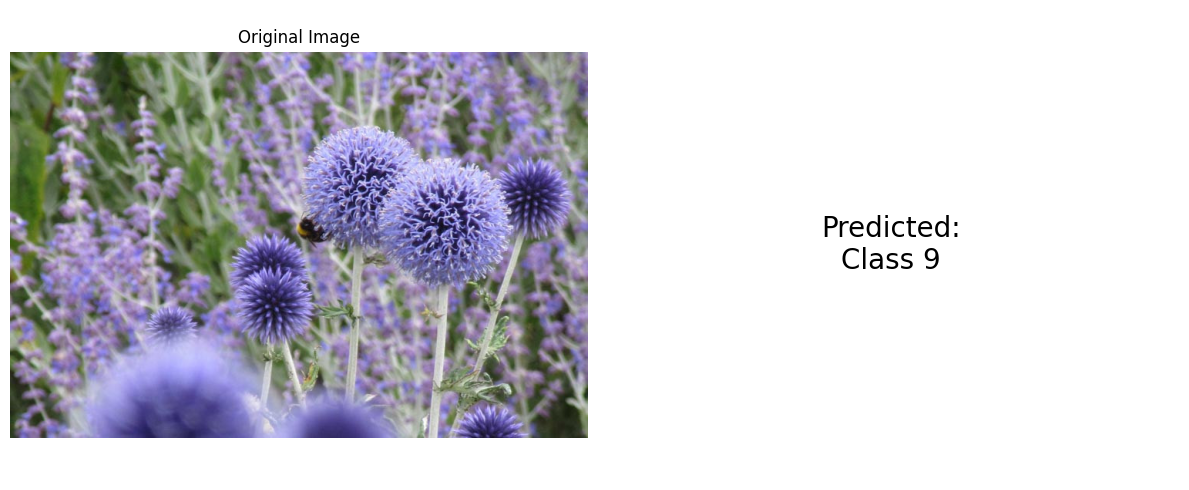

Predicted class: Class 9


In [50]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_display_image(model, image_path, class_names):
    model.eval()
    # Open and display original image
    original_image = Image.open(image_path).convert('RGB')
    
    # Prepare image for model
    image = transform(original_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    predicted_class = class_names[predicted.item()]
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Display original image
    ax1.imshow(original_image)
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    # Display prediction
    ax2.text(0.5, 0.5, f'Predicted:\n{predicted_class}', 
             horizontalalignment='center', verticalalignment='center', fontsize=20)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class

# Test on a new image
new_image_path = 'globethistle2.webp'
prediction = predict_and_display_image(model, new_image_path, class_names)
print(f'Predicted class: {prediction}')